# Goal

Can I create the 7th energy level of a Quantum Harmonic Oscillator, defined by $H = \frac{P^2}{2m} + \frac{1}{2}m \omega^2 X^2$, by fine tuning the $\omega$ parameter to follow a $\omega_t$ evolution?

# Imports

In [370]:
from cProfile import label
from copy import deepcopy
from dataclasses import dataclass
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from scipy.sparse.linalg import expm
from typing import List
import numpy as np
import scipy
import seaborn as sns

plt.figure(figsize=(20,3))

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

In [371]:
@dataclass
class Settings:
    number_of_energy_levels = 30
    omega = 10
    resolution = 100
    x_max = 3
    x_min = -3
    total_evolution_time = 30
    n_time_intervals = 10

# Setup Hamiltonian

In [372]:
valid_x = np.linspace(Settings.x_min, Settings.x_max, Settings.resolution)
delta_x = valid_x[1] - valid_x[0]
potential = lambda x: x**2

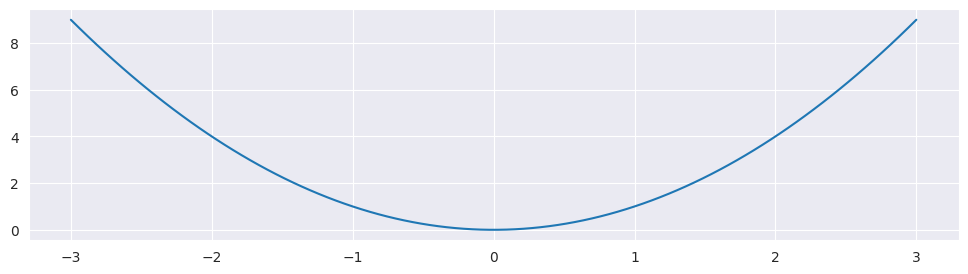

In [373]:
plt.figure(figsize=(12,3))
plt.plot(valid_x, [potential(x) for x in valid_x])

In [374]:
# Based on https://medium.com/@natsunoyuki/quantum-mechanics-with-python-de2a7f8edd1f
def generate_hamiltonian(omega: float):
    # P^2 term
    temp_hamiltonian = scipy.sparse.eye(Settings.resolution, Settings.resolution, format='lil') * 2
    for i in range(Settings.resolution - 1):
        temp_hamiltonian[i, i + 1] = -1
        temp_hamiltonian[i + 1, i] = -1


    # # Turns the space cyclic. Useful for modelling ring interferometry
    # inner_hamiltonian[0, resolution - 1] = -1
    # inner_hamiltonian[resolution - 1, 0] = -1

    temp_hamiltonian = np.divide(temp_hamiltonian, delta_x ** 2)

    # V(X) term
    for i in range(Settings.resolution):
        temp_hamiltonian[i, i] = temp_hamiltonian[i, i] + omega**2 * valid_x[i]**2

    return temp_hamiltonian.tocsc()

hamiltonian = generate_hamiltonian(omega=Settings.omega)

# Energy levels

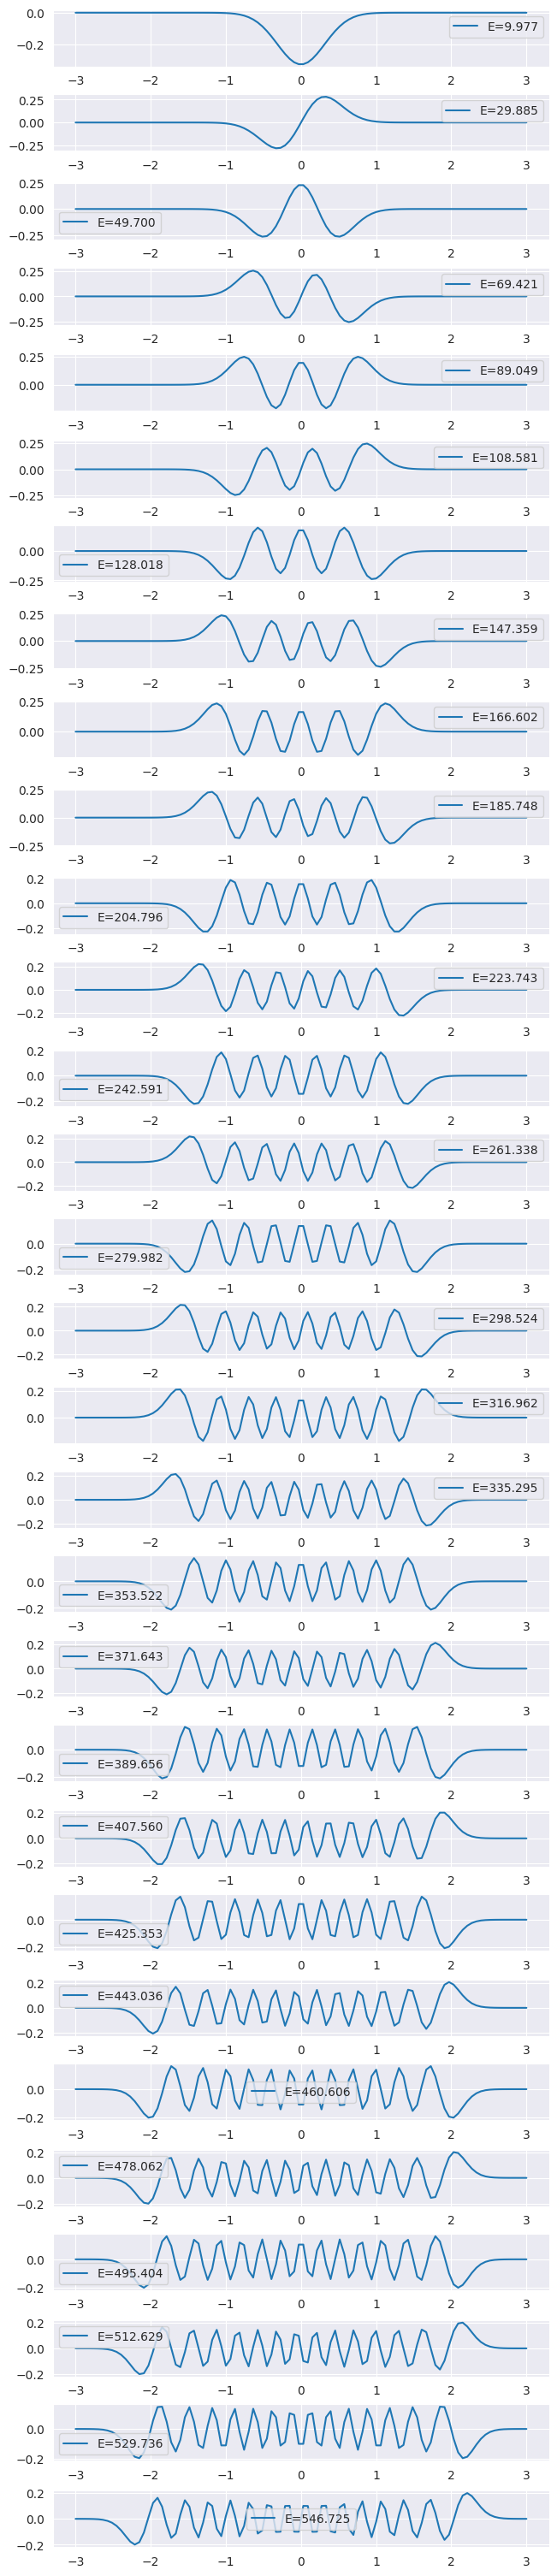

In [375]:
eigenvalues, eigenvectors = scipy.sparse.linalg.eigs(hamiltonian, k=Settings.number_of_energy_levels, which="SM")
fig, axes = plt.subplots(Settings.number_of_energy_levels, 1, layout='constrained')
fig.set_figheight(Settings.number_of_energy_levels)
for i, (val, vector) in enumerate(zip(eigenvalues, eigenvectors.T)):
    axes[i].plot(valid_x, vector, label=f"E={np.real(val):.3f}")
    axes[i].legend(loc='best')

plt.show()

# Orthonormality check

<Axes: >

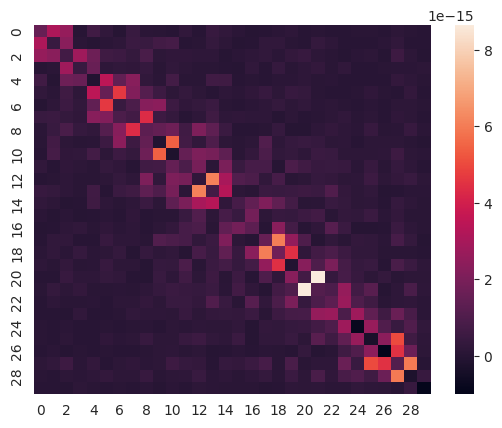

In [376]:
# Ideally this should all be zeroes
error_matrix = np.abs(eigenvectors.T @ eigenvectors) - np.eye(Settings.number_of_energy_levels)
sns.heatmap(error_matrix)

# Origin state

/home/mcosta/.cache/pypoetry/virtualenvs/collapsedwave-FzXm3nz_-py3.12/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/mcosta/.cache/pypoetry/virtualenvs/collapsedwave-FzXm3nz_-py3.12/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


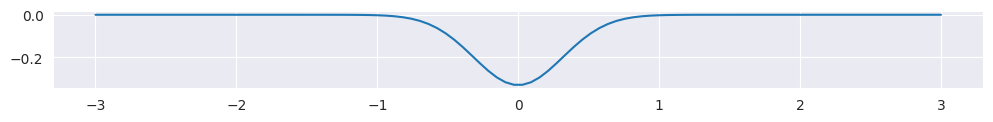

In [377]:
origin_state = eigenvectors[:, 0]
plt.figure(figsize=(12,1))
plt.plot(valid_x, origin_state)

# Target state

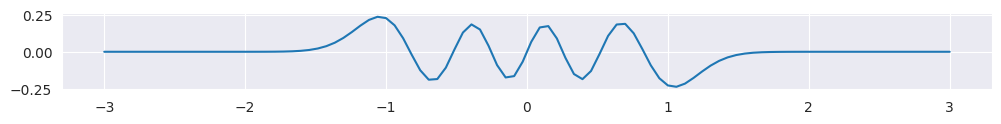

In [378]:
target_state = eigenvectors[:, 7]
plt.figure(figsize=(12,1))
plt.plot(valid_x, target_state)

In [379]:
def fidelity(state_a: np.ndarray, state_b: np.ndarray) -> float:
    return np.sum(np.abs(np.dot(state_a, state_b)) ** 2)

print(fidelity(state_a=origin_state, state_b=origin_state))
print(fidelity(state_a=target_state, state_b=target_state))
print(fidelity(state_a=origin_state, state_b=target_state))

1.0000000000000036
1.0000000000000027
1.733336949949225e-31


# Optimization

We will split the time evolution into time_intervals. We want to find a vector of time choices that maximizes the final fidelity between the target state, and the evolved state

In [380]:
def fidelity(state_a: np.ndarray, state_b: np.ndarray) -> float:
    return np.sum(np.abs(np.dot(state_a, state_b)) ** 2)

$\ket{\phi_t} = e^{iHt} \ket{\phi_0}$

In [381]:
def evolve_state(omega_list: List[float]) -> List[float]:
    evolved_state = deepcopy(origin_state)
    time_delta = Settings.total_evolution_time / Settings.n_time_intervals
    for temp_omega in omega_list:
        evolved_state = expm(-1j * generate_hamiltonian(omega=temp_omega) * time_delta) @ evolved_state
    return evolved_state

In [382]:
def loss(omega_list: List[float]) -> float:
    evolved_state = evolve_state(omega_list)
    return np.sum([1 - fidelity(evolved_state, target_state)])

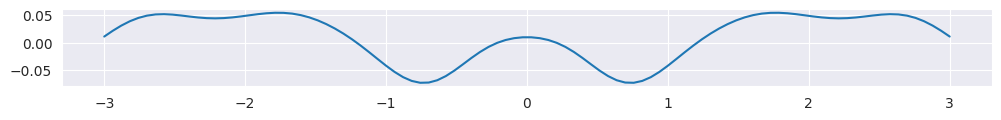

In [389]:
plt.figure(figsize=(12,1))
plt.plot(valid_x, evolve_state(omega_list=np.ones(10)))

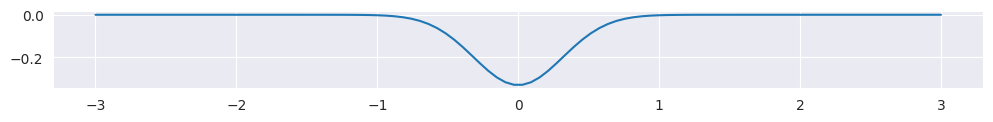

In [390]:
plt.figure(figsize=(12,1))
plt.plot(valid_x, origin_state)

In [391]:
fidelity(evolve_state(omega_list=np.ones(10)), origin_state)

0.2515198462321121

In [383]:
def plot_waves(omega_list: List[float], show_fidelity:bool = True) -> None:
    assert len(omega_list) == Settings.n_time_intervals, f"We need {Settings.n_time_intervals} 'omegas'"
    evolved_state = deepcopy(origin_state)
    time_delta = Settings.total_evolution_time / Settings.n_time_intervals

    fig, axes = plt.subplots(Settings.n_time_intervals + 1, 1, layout='constrained')
    fig.set_figheight(Settings.n_time_intervals * 2)
    axes[0].plot(valid_x, evolved_state)
    axes[0].plot(valid_x, np.real(evolved_state), label="Real")
    axes[0].plot(valid_x, np.imag(evolved_state), label="Imag")
    if show_fidelity:
        axes[0].plot([] , [], label=f"$\\mathcal{{F}}={fidelity(evolved_state, target_state):.2f}$")
    axes[0].legend(loc="best")

    for i, temp_omega in enumerate(omega_list):
        evolved_state = expm(-1j * generate_hamiltonian(omega=temp_omega) * time_delta) @ evolved_state
        axes[i+1].plot(valid_x, np.real(evolved_state), label="Real")
        axes[i+1].plot(valid_x, np.imag(evolved_state), label="Imag")
        if show_fidelity:
            axes[i+1].plot([] , [], label=f"$\\mathcal{{F}}={fidelity(evolved_state, target_state):.2f}$")
            axes[i+1].plot([] , [], label=f"$\\omega={temp_omega:.2f}$")
        axes[i+1].legend(loc="best")

In [384]:
results = minimize(loss, x0 = np.ones(Settings.n_time_intervals))
results

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.0
        x: [ 1.000e+00  1.000e+00  1.000e+00  1.000e+00  1.000e+00
             1.000e+00  1.000e+00  1.000e+00  1.000e+00  1.000e+00]
      nit: 0
      jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
             0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 hess_inv: [[1 0 ... 0 0]
            [0 1 ... 0 0]
            ...
            [0 0 ... 1 0]
            [0 0 ... 0 1]]
     nfev: 11
     njev: 1

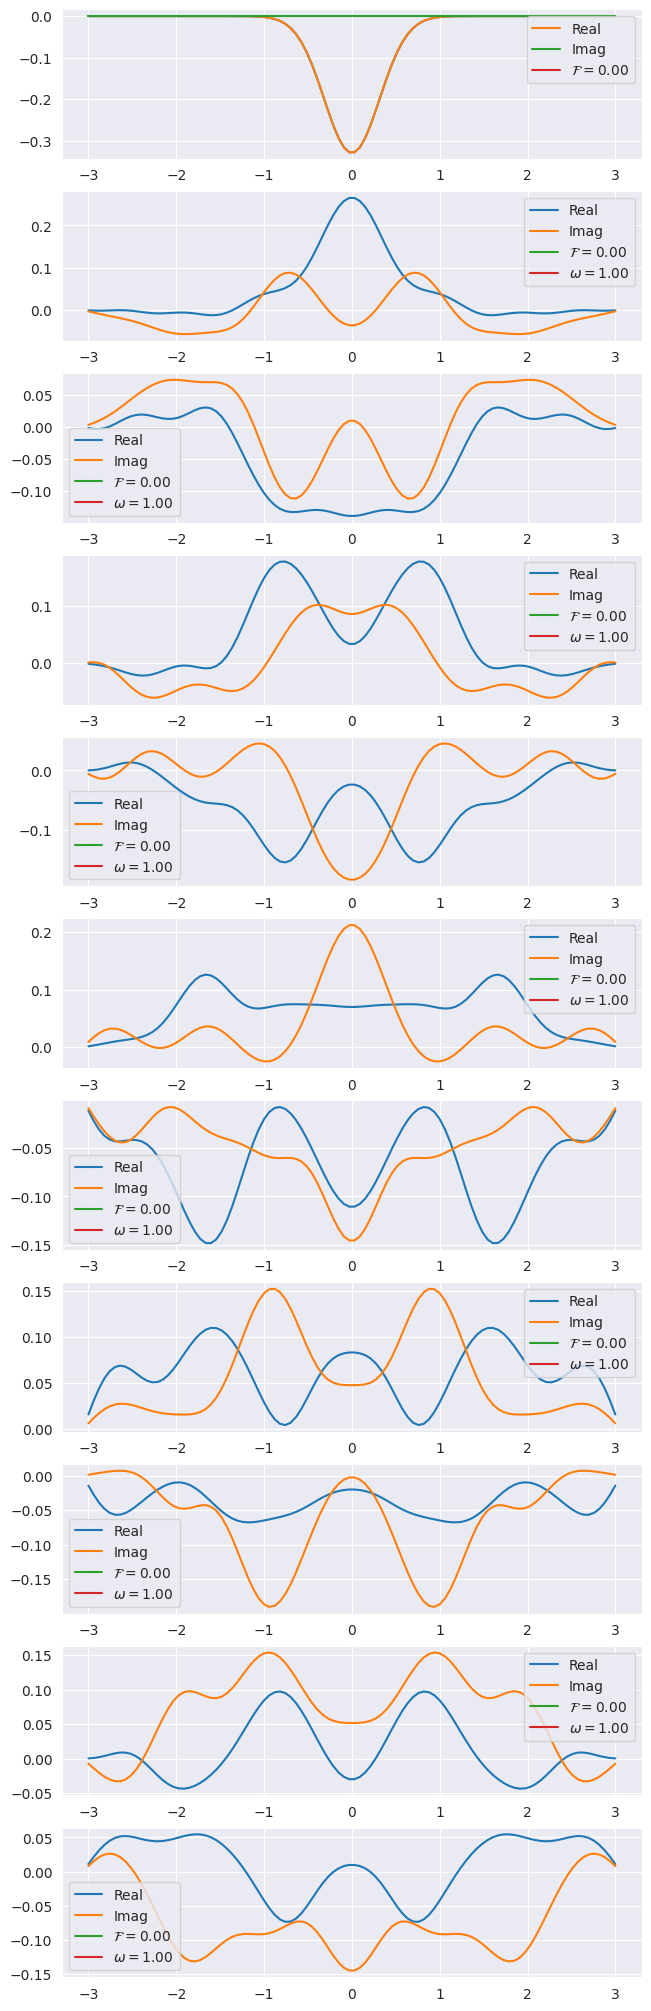

In [385]:
plot_waves(results.x)

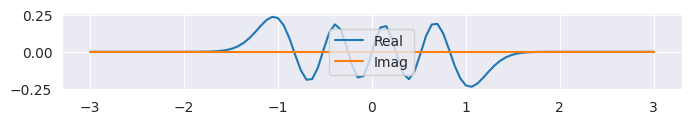

In [386]:
plt.figure(figsize=(8,1))
plt.plot(valid_x, np.real(target_state), label="Real")
plt.plot(valid_x, np.imag(target_state), label="Imag")
plt.legend(loc="best")